In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
model = keras.models.load_model('../snapshots/resnet50_csv_06-10kbatch.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

c:\programdata\anaconda3\lib\site-packages\keras-2.1.2-py3.6.egg\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [3]:
def add_noise(inData):
    result = np.random.normal(inData, scale=0.5).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

def set_to_zero(inData):
    result = np.zeros(inData.shape).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

In [4]:


# create a generator for testing data
validation_generator = CSVGenerator(
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\annotation2.txt',
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\classname2.txt',
                val_image_data_generator,
                batch_size=10
            )

In [ ]:
# load image
index = np.random.randint(0,16800)
image = validation_generator.load_image(index)
print(image.shape)

In [ ]:
# use this block to test against actual image
# image = cv2.imread("testImg/cellBaseRotated3.bmp.png")
#image = cv2.imread("C:\\Users\\Kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
image = cv2.imread("\\\\KAI-LAPTOP\\Users\\kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
print(image.shape)

In [ ]:
image = add_noise(image)

In [ ]:

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = validation_generator.preprocess_image(image)
print(image.shape)
image, scale = validation_generator.resize_image(image)
print(image.shape)
annotations = validation_generator.load_annotations(index)

print(index)
print(validation_generator.image_path(index))
print(scale)
print(annotations)


In [ ]:
# process image
start = time.time()
detections = None
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
print(predicted_labels)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
# correct for image scale
detections[0, :, :4] /= scale

In [ ]:

# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.1:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

print(b[0]+50)
print(b[1]+50)

In [ ]:
print(detections[0:3])

In [ ]:
print(scores[0:3])

# Define function to return 2D pose from image file

In [5]:
def get2DPose():
    image = cv2.imread("\\\\KAI-LAPTOP\\Users\\kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
    print(image.shape)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = validation_generator.preprocess_image(image)
    print(image.shape)
    image, scale = validation_generator.resize_image(image)
    print(image.shape)
    print(scale)
    
    # process image
    start = time.time()
    detections = None
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    # correct for image scale
    detections[0, :, :4] /= scale
    
    b = None
    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.1:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        className = validation_generator.label_to_name(label)
        caption = "{} {:.3f}".format(className, score)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    if (b == None):
        return -999, -999, -999
    
    print(b[0]+50)
    print(b[1]+50)
    angle = int(className.split('_')[1])
    print(angle)
    
    return b[0]+50, b[1]+50, angle

# Create Server to respond to identification request

In [7]:
import socket
import time

HOST = "192.168.1.115" #The remote host
PORT = 3001 # The same port as used by the server
print("Starting 2d id program")

Starting 2d id program


In [ ]:
returnVal = None

Waiting for connections...
Connected
received: getCircuitOrigin
(598, 830, 3)
(598, 830, 3)
(600, 833, 3)
1.0033444816053512
processing time:  0.32787179946899414


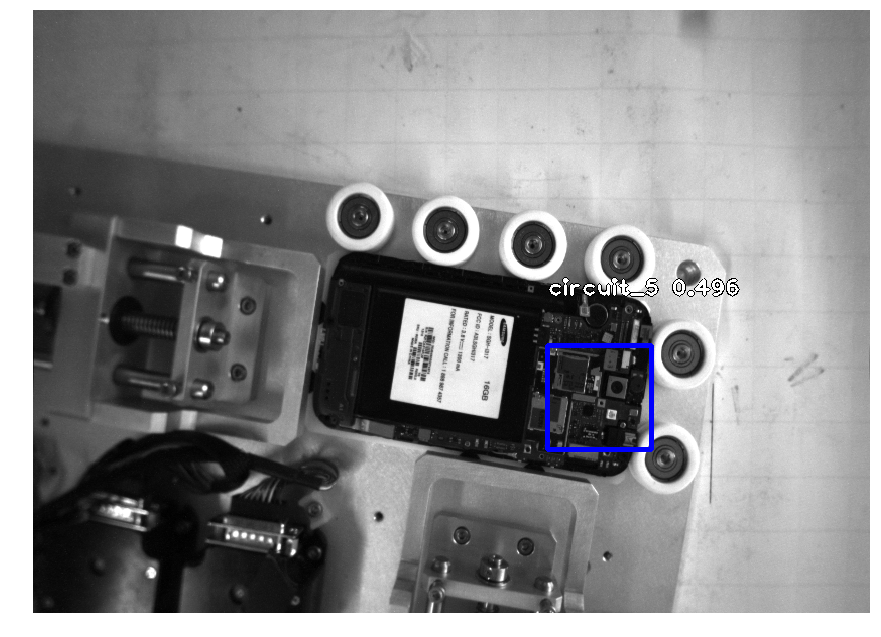

560
383

sending:   -0.0736,   0.0874,  -0.0280,  0.000,  0.000,  0.000
Waiting for connections...
Connected
received: getOrigin
( -0.0736,   0.0874,  -0.0280,  0.000,  0.000,  0.000)

Waiting for connections...
Connected
received: end


In [14]:
finishedLoop = False
while finishedLoop == False:
    print("Waiting for connections...")
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((HOST, PORT)) # Bind to the port 
    s.listen(5) # Now wait for client connection.
    c, addr = s.accept() # Establish connection with client.
    print("Connected")
    foundError = False
    finishedInner = False
    while foundError == False and finishedInner == False:
        try:
            msg = c.recv(40).decode("utf-8")
            if msg != "":
                print("received: " + msg)
            time.sleep(1)
            if msg == "getCircuitOrigin":
                x,y,a = get2DPose()
                if x == -999:
                    returnVal = "None Found"
                else:    
                    x = (-0.4326 * x + 168.96)/1000.0
                    y = (-0.4232 * y + 249.5)/1000.0
                    z = -28.0/1000.0
                    rx = 0.0
                    ry = 0.0
                    rz = 0.0
                    returnVal = "{0:8.4f}, {1:8.4f}, {2:8.4f}, {3:6.3f}, {4:6.3f}, {5:6.3f}".format(x, y, z, rx, ry, rz)
                print("sending: ", returnVal)
                c.send(returnVal.encode())
                finishedInner = True
            elif msg == "getOrigin":
                returnString = "({})\n".format(returnVal)
                c.send(returnString.encode())
                print(returnString)
                finishedInner = True
            elif msg == "end":
                finishedLoop = True
                finishedInner = True
        except socket.error as socketError:
            print(socketError)
            foundError = True
    c.close()
    s.close()

# Tests

In [ ]:
x,y,a = get2DPose()